<a href="https://colab.research.google.com/github/juannMGC/ING-SOFTWARE-II/blob/main/Sprint1/RedNeuronalTrasporte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import tkinter as tk
import seaborn as sns
import plotly.express as px
import tensorflow
from tkinter import ttk
from tkinter import filedialog
from tkinter import messagebox
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense


LECTURA DATA SET

In [138]:
def leer_excel(ruta_archivo):
    try:
        # Lee el archivo de Excel
        datos = pd.read_excel(ruta_archivo, engine='openpyxl')

        # Imprime los datos en pantalla
        print("Contenido del archivo de Excel:")
        print(datos)

        return datos

    except Exception as e:
        print(f"Error al leer el archivo: {e}")
        return None

# Ejemplo de uso de la función
archivo_excel = "DataNovenoProcesamientoVx.xlsx"
datos = leer_excel(archivo_excel)

Contenido del archivo de Excel:
       Ruta  Hora  Dia  Cond_Ruta  #Veh_Disp_x_rut  demanda  DistRut_Km  \
0         1     3    3          1                5        2       13.61   
1         1     3    3          2                5        2       13.61   
2         1     3    3          3                5        2       13.61   
3         1     3    3          1                5        2       13.61   
4         1     3    3          2                5        2       13.61   
...     ...   ...  ...        ...              ...      ...         ...   
25699    68     1    1          2                2        1       17.78   
25700    68     1    1          3                2        1       17.78   
25701    68     1    1          1                2        1       17.78   
25702    68     1    1          2                2        1       17.78   
25703    68     1    1          3                2        1       17.78   

       TimeRuta  PromPasDia  
0            28        1566  
1      

Min Max para normalizar

In [139]:
# Cargar el archivo Excel
archivo_excel = "DataNovenoProcesamientoVx.xlsx"
data = pd.read_excel(archivo_excel)

# Definir los rangos específicos para cada columna
rangos = {
    "Ruta": (1, 60),
    "Hora": (1, 3),
    "Dia": (1, 3),
    "Cond_Ruta": (1, 3),
    "#Veh_Disp_x_rut": (2, 4),
    "demanda": (1, 3),
    "DistRut_Km": (7, 22.6),
    "TimeRuta": (11, 55),
    "PromPasDia":(72, 4884)
}

# Normalizar las columnas utilizando Min-Max
scaler = MinMaxScaler()

for columna, (min_valor, max_valor) in rangos.items():
    columna_data = data[[columna]].values.reshape(-1, 1)
    data[columna] = scaler.fit_transform(columna_data) * (max_valor - min_valor) + min_valor

# Guardar los datos normalizados en un nuevo archivo Excel
data.to_excel("DataDecimoProcesamientoVx_Normalizado.xlsx", index=False)


In [140]:
# Muestra las primeras filas del DataFrame para verificar la normalización de #Veh_x_rut
print(datos.head())

   Ruta  Hora  Dia  Cond_Ruta  #Veh_Disp_x_rut  demanda  DistRut_Km  TimeRuta  \
0     1     3    3          1                5        2       13.61        28   
1     1     3    3          2                5        2       13.61        28   
2     1     3    3          3                5        2       13.61        28   
3     1     3    3          1                5        2       13.61        28   
4     1     3    3          2                5        2       13.61        28   

   PromPasDia  
0        1566  
1        1566  
2        1566  
3        1566  
4        1566  


In [141]:
corr_matrix = datos.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

,Ruta,Hora,Dia,Cond_Ruta,#Veh_Disp_x_rut,demanda,DistRut_Km,TimeRuta,PromPasDia
Ruta,1.000000,0.000000,-0.000000,0.000000,-0.258481,-0.163816,-0.041726,0.059432,-0.208883
Hora,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
Dia,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cond_Ruta,0.000000,-0.000000,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
#Veh_Disp_x_rut,-0.258481,0.000000,0.000000,-0.000000,1.000000,0.680870,0.195686,0.167796,0.753286
demanda,-0.163816,0.000000,0.000000,-0.000000,0.680870,1.000000,0.147326,0.141765,0.740168
DistRut_Km,-0.041726,0.000000,0.000000,-0.000000,0.195686,0.147326,1.000000,0.698542,0.254852
TimeRuta,0.059432,-0.000000,0.000000,-0.000000,0.167796,0.141765,0.698542,1.000000,0.266728
PromPasDia,-0.208883,0.000000,0.000000,-0.000000,0.753286,0.740168,0.254852,0.266728,1.000000


In [142]:
col_drop = ['Ruta','Hora','Dia','Cond_Ruta'] #no contienen información de interes o es confusa
datos.drop(columns = col_drop, inplace = True)
datos.head()

,#Veh_Disp_x_rut,demanda,DistRut_Km,TimeRuta,PromPasDia
0,5,2,13.61,28,1566
1,5,2,13.61,28,1566
2,5,2,13.61,28,1566
3,5,2,13.61,28,1566
4,5,2,13.61,28,1566


In [143]:
datos

,#Veh_Disp_x_rut,demanda,DistRut_Km,TimeRuta,PromPasDia
0,5,2,13.61,28,1566
1,5,2,13.61,28,1566
2,5,2,13.61,28,1566
3,5,2,13.61,28,1566
4,5,2,13.61,28,1566
...,...,...,...,...,...
25699,2,1,17.78,50,96
25700,2,1,17.78,50,96
25701,2,1,17.78,50,96
25702,2,1,17.78,50,96



SEPARACION DE CARACTERISTICAS Y ETIQUETAS

In [144]:
from sklearn.model_selection import StratifiedKFold
# Se define el número de folds para la validación cruzada
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
X = datos[['#Veh_Disp_x_rut', "DistRut_Km",	"TimeRuta","PromPasDia"]]
Y = datos[['demanda']]

DIVISION DE DATOS: Validacion Cruzada k=

In [145]:

# Se inicializa una lista para almacenar los porcentajes de pérdida en cada fold
porcentajes_perdida = []
from sklearn.model_selection import train_test_split
# Itera sobre los folds de la validación cruzada
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

#X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=42)

FASE DE DISEÑO DE LA MLP  

In [146]:
from keras.metrics import RootMeanSquaredError
model = Sequential()

# Se agrega capa inicial con 4 Neuronas y función de activación "relu"
model.add(Dense(units=4, input_dim=4, activation='relu'))

# Se agregan más capas si es necesario
model.add(Dense(units=3, activation='relu'))
model.add(Dense(units=3, activation='relu'))
model.add(Dense(units=1, activation= 'linear'))

# Se crea un optimizador Adam con tasa de aprendizaje = 0.01
custom_optimizer = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError()])

model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0)

In [147]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 3)                 15        
                                                                 
 dense_14 (Dense)            (None, 3)                 12        
                                                                 
 dense_15 (Dense)            (None, 1)                 4         
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


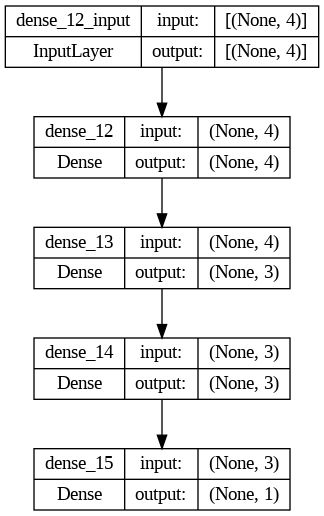

In [148]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

Una vez establecida la arquitectura del modelo, es el momento de entrenar el modelo. Podemos ajustar los hiperparímetros: epoch (el número de iteraciones de entrenamiento) y batch_size (el número de filas a incluir en una sola propagación hacia adelante y hacia atrás). Incluiremos una división de validación de 0.1 (de forma predeterminada, tomará el 10% de las últimas filas y las usará como datos de validación, que no se usan para el entrenamiento, pero podemos usarlas para evaluar datos no vistos para cada paso dado).



In [149]:
# Entrenar el modelo
history = model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
322/322 [==============================] - 2s 6ms/step - loss: 0.3794 - root_mean_squared_error: 0.6159 - val_loss: 0.3904 - val_root_mean_squared_error: 0.6248
Epoch 2/10
322/322 [==============================] - 2s 6ms/step - loss: 0.3731 - root_mean_squared_error: 0.6109 - val_loss: 0.3836 - val_root_mean_squared_error: 0.6193
Epoch 3/10
322/322 [==============================] - 2s 7ms/step - loss: 0.3659 - root_mean_squared_error: 0.6049 - val_loss: 0.3759 - val_root_mean_squared_error: 0.6131
Epoch 4/10
322/322 [==============================] - 2s 6ms/step - loss: 0.3581 - root_mean_squared_error: 0.5984 - val_loss: 0.3676 - val_root_mean_squared_error: 0.6063
Epoch 5/10
322/322 [==============================] - 2s 6ms/step - loss: 0.3496 - root_mean_squared_error: 0.5912 - val_loss: 0.3588 - val_root_mean_squared_error: 0.5990
Epoch 6/10
322/322 [==============================] - 1s 3ms/step - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.3492 - val_

Después de ajustar nuestro conjunto de entrenamiento con el modelo, podemos evaluar si nuestro modelo se ajusta demasiado al conjunto de entrenamiento o no. Una forma de hacerlo es trazando las funciones de pérdida en cada paso del entrenamiento.

In [150]:
def plot_training(training_history, text, width):
    history = training_history.history[text]

    # creates a moving average plot to reduce variations
    moving_average = [float("NaN") for i in range(width)]
    for i in range(width, len(history)+1):
        moving_average.append(np.mean(np.array(history[i-width:i+1])))

    plt.plot(history)
    plt.plot(moving_average)
    plt.title(text)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['value','moving average'], loc='upper left')
    plt.show()

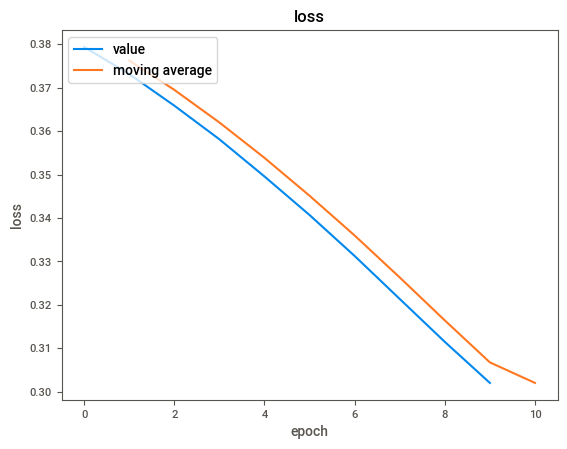

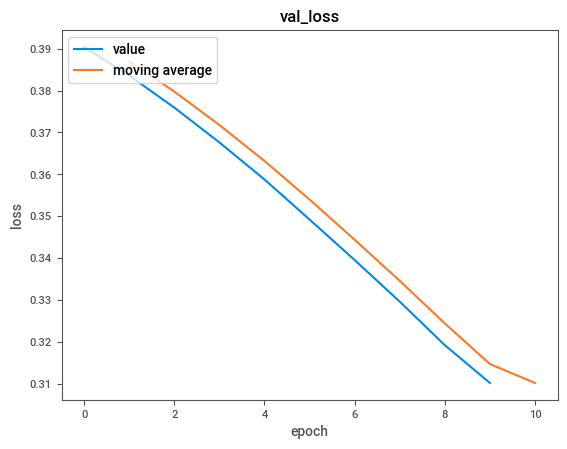

In [151]:
# Plots the loss (MSE and RMSE) of both test and validation data
WIDTH = 1
plot_training(history,'loss',WIDTH)
plot_training(history,'val_loss',WIDTH)
#plot_training(history,'val_root_mean_squared_error',WIDTH)
#plot_training(history,'root_mean_squared_error',WIDTH)

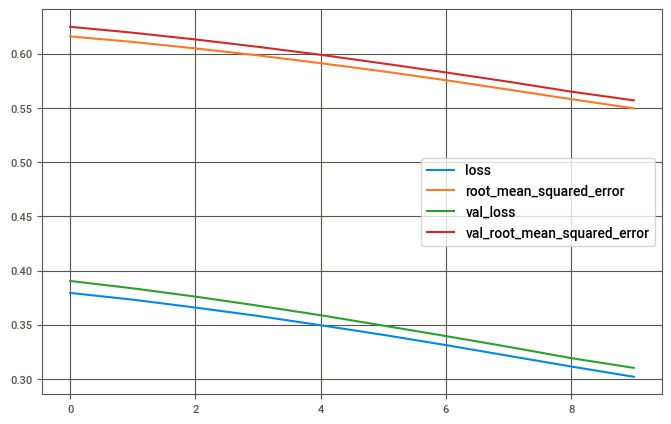

In [152]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(10,19000000000)
plt.show()

In [153]:
predicted_y_DeepL = model.predict(X_test)

161/161 [==============================] - 0s 2ms/step


In [154]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y_test, predicted_y_DeepL)
print(lin_mae)

0.3978202794312503


In [155]:
from sklearn.metrics import r2_score
r2_Deep = r2_score(Y_test,predicted_y_DeepL)
print('r2 para el modelo deep learning', r2_Deep)

r2 para el modelo deep learning 0.46086388556846014


In [156]:
'''------------SEGUNDA MATRIZ DE CORRELACIONES-------------'''
Xtrain_pre2 = datos.copy()
Xtrain_pre2['output'] = Y_train  #Recordems que output es la variable de desicion
corr_matrix2 = Xtrain_pre2.corr()#matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')


,#Veh_Disp_x_rut,demanda,DistRut_Km,TimeRuta,PromPasDia,output
#Veh_Disp_x_rut,1.000000,0.680870,0.195686,0.167796,0.753286,0.683688
demanda,0.680870,1.000000,0.147326,0.141765,0.740168,1.000000
DistRut_Km,0.195686,0.147326,1.000000,0.698542,0.254852,0.146768
TimeRuta,0.167796,0.141765,0.698542,1.000000,0.266728,0.143927
PromPasDia,0.753286,0.740168,0.254852,0.266728,1.000000,0.742603
output,0.683688,1.000000,0.146768,0.143927,0.742603,1.000000


In [157]:
# Evalúa el modelo y calcula el error cuadrático medio
predictions = model.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
# Calcula y almacena el porcentaje de pérdida para este fold
rango_etiquetas = 3 - 1
porcentaje_perdida = (mse / rango_etiquetas) * 100
porcentajes_perdida.append(porcentaje_perdida)

# Calcula y muestra el promedio del porcentaje de pérdida en los 5 folds
promedio_perdida = sum(porcentajes_perdida) / len(porcentajes_perdida)
print(f"Porcentaje de error promedio en los 5 folds: {promedio_perdida:.2f}%")

161/161 [==============================] - 0s 1ms/step
Porcentaje de error promedio en los 5 folds: 15.51%


FASE DE PRODUCCION

In [158]:
loss = model.evaluate(X_test, Y_test)
# Calcular el porcentaje de pérdida
rango_etiquetas = 3 - 1  # Rango de las etiquetas (de 1 a 3 en este caso)
 # Calcular el porcentaje de pérdida
porcentaje_perdida = (loss[0] / rango_etiquetas) * 100
#porcentaje_perdida = (loss / rango_etiquetas) * 100

# Mostrar el porcentaje de pérdida
print(f"Porcentaje de error en el conjunto de prueba: {porcentaje_perdida:.2f}%")


161/161 [==============================] - 0s 2ms/step - loss: 0.3102 - root_mean_squared_error: 0.5570
Porcentaje de error en el conjunto de prueba: 15.51%


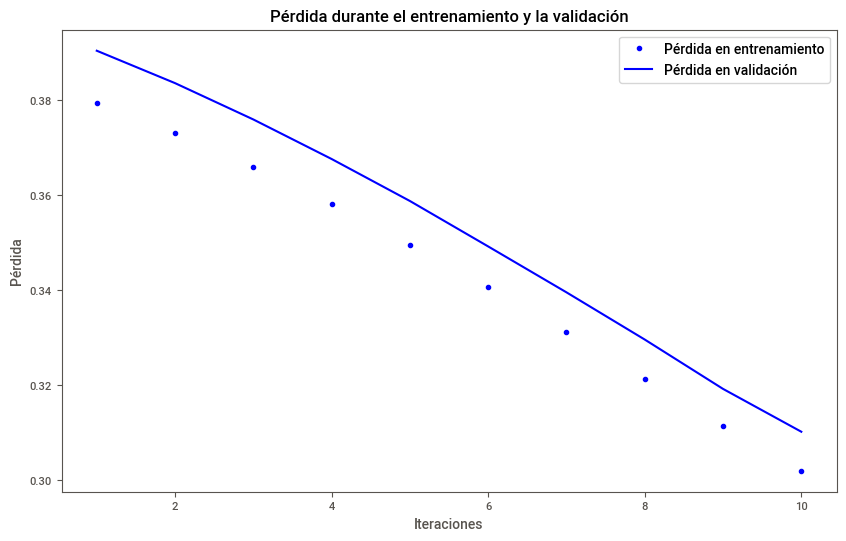

In [159]:
# Obtener la pérdida del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de línea para mostrar la pérdida durante el entrenamiento
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

161/161 [==============================] - 0s 1ms/step


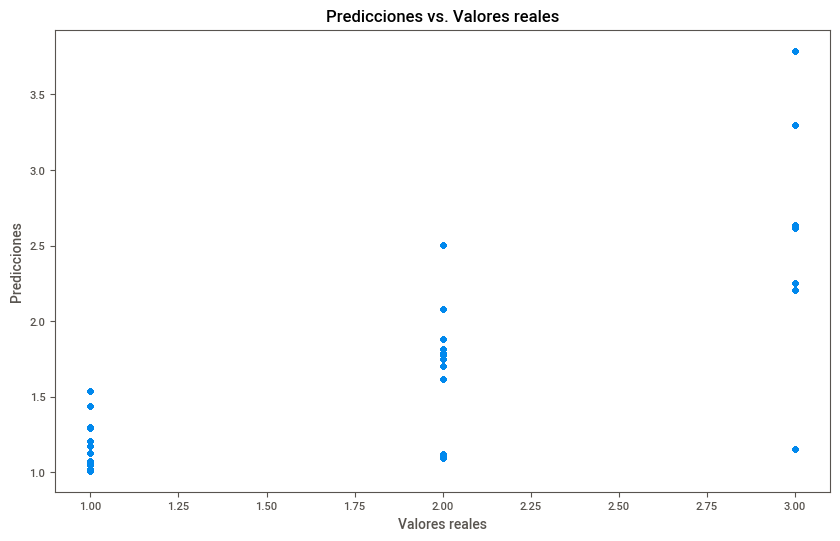

In [160]:
predictions = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, predictions)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()

161/161 [==============================] - 0s 2ms/step


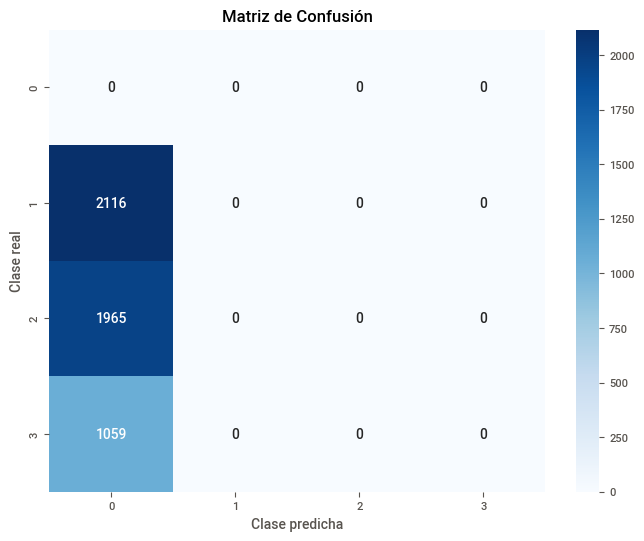

In [161]:
# Obtener las probabilidades de las clases del modelo
probabilidades = model.predict(X_test)

# Obtener las clases predichas
predictions = np.argmax(probabilidades, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(Y_test, predictions)

# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')
plt.title('Matriz de Confusión')
plt.show()

#matriz de confusión

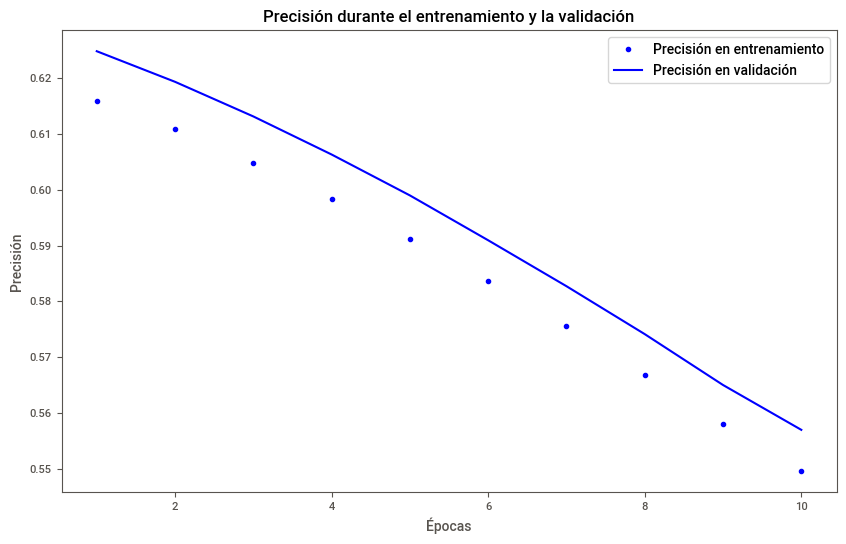

In [162]:

accuracy = history.history['root_mean_squared_error']
val_accuracy = history.history['val_root_mean_squared_error']

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo', label='Precisión en entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión en validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()



EVALUAR PREDICCION

Ahora es el momento de evaluar qué tan bueno es nuestro modelo. Añadimos una media móvil como línea de base. La razón por la que necesitamos una línea de base es para ver si nuestra puntuación RMSE y la puntuación de Spearman son realmente buenas, no solo debido a conjeturas aleatorias.

In [163]:
def predict_and_calc_score(X, Y):
    # prediction of Y using the model
    pred = model.predict(X)
    # moving average of Y
    window_size = 12
    moving_average = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=0, arr=Y)
    moving_average = np.concatenate((np.zeros((1, Y.shape[1])), moving_average), axis=0)[:Y.shape[0]]

    # scale it back to the original scale
    pred_scaled = scaler_Y.inverse_transform(pred)
    moving_average_scaled = scaler_Y.inverse_transform(moving_average)
    Y_scaled = scaler_Y.inverse_transform(Y)

    # calculate the RMSE
    baseline_RMSE = np.sqrt(np.mean((Y_scaled - moving_average_scaled) ** 2))
    model_RMSE = np.sqrt(np.mean((Y_scaled - pred_scaled) ** 2))

    return Y_scaled, pred_scaled, moving_average_scaled, model_RMSE, baseline_RMSE

def plot_prediction(actual, prediction, moving_average):
    # Plot the actual values
    plt.plot(actual, label="True value", linestyle='-', linewidth=1, marker='s', markersize=1)

    # Plot the moving average
    plt.plot(moving_average, label="Moving Average", linestyle='--', linewidth=1, marker='s', markersize=1)

    # Plot the predicted values
    plt.plot(prediction, label="Prediction", linestyle='--', linewidth=1, marker='o', markersize=1)

    # Set the title and axis labels
    plt.title('Prediction vs. True Value', fontsize=16)
    plt.xlabel('Hour Timesteps')
    plt.ylabel('Output Value')

    # Add a legend to the plot
    plt.legend(loc='upper left', fontsize=12)

    # Display the plot
    plt.show()

In [164]:
from scipy.stats import spearmanr

scaler_Y = StandardScaler()
scaler_Y.fit(Y_train)
train_actual, train_prediction, train_moving_average, train_RMSE, baseline_RMSE = \
    predict_and_calc_score(X_train, Y_train)

print("Train Moving Average RMSE:", baseline_RMSE)
print("Train Prediction RMSE:", train_RMSE)

corr, pval = spearmanr(train_actual, train_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = spearmanr(train_actual, train_prediction)
pred_spearman_corr = np.mean(corr)


print("Train Moving Average Spearman Correlation:", mov_spearman_corr)
print("Train Prediction Spearman Correlation:", pred_spearman_corr)

643/643 [==============================] - 1s 1ms/step
Train Moving Average RMSE: 0.05162489484038039
Train Prediction RMSE: 0.4134836524574212
Train Moving Average Spearman Correlation: 0.9934766795216582
Train Prediction Spearman Correlation: 0.7396037065764375


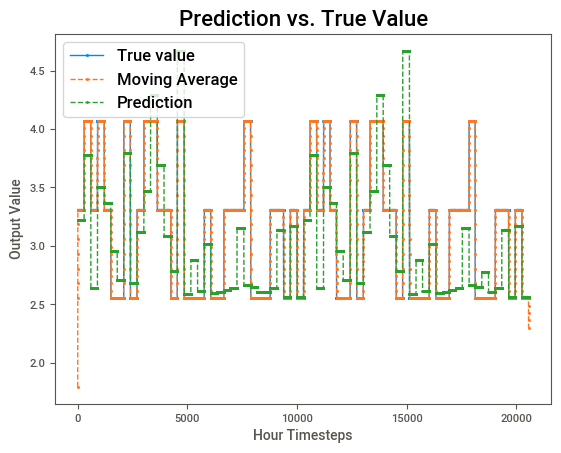

In [165]:
location = 0
plot_prediction(train_actual[:,location], train_prediction[:,location], train_moving_average[:,location])

El tren RMSE y Spearman es bueno. Es mejor que la media móvil y muestra que el modelo no se está ajustando por debajo. Sin embargo, la verdadera prueba radica en la evaluación de la prueba (ya que los modelos de redes neuronales pueden sobreajustarse).

In [166]:
train_actual, train_prediction, train_moving_average, train_RMSE, baseline_RMSE = \
    predict_and_calc_score(X_test, Y_test)

print("Train Moving Average RMSE:", baseline_RMSE)
print("Train Prediction RMSE:", train_RMSE)

corr, pval = spearmanr(train_actual, train_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = spearmanr(train_actual, train_prediction)
pred_spearman_corr = np.mean(corr)


print("Train Moving Average Spearman Correlation:", mov_spearman_corr)
print("Train Prediction Spearman Correlation:", pred_spearman_corr)

161/161 [==============================] - 0s 2ms/step
Train Moving Average RMSE: 0.10325983294615886
Train Prediction RMSE: 0.4224323884461905
Train Moving Average Spearman Correlation: 0.9754756238301165
Train Prediction Spearman Correlation: 0.7265195103781186


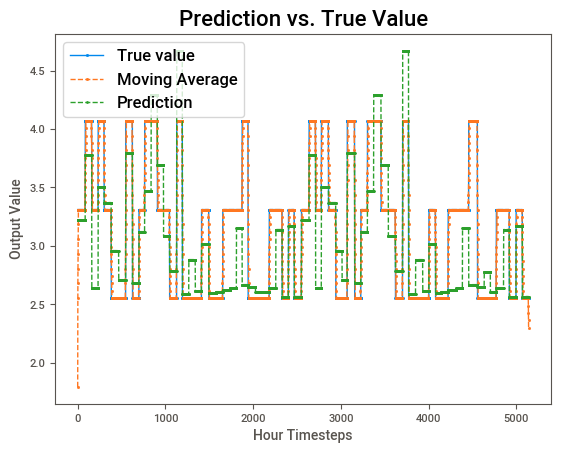

In [167]:
location = 0
plot_prediction(train_actual[:, location], train_prediction[:, location], train_moving_average[:, location])

¡La prueba RMSE y Spearman también es buena! Es mejor que la media móvil y muestra que el modelo no está sobreajustado y puede generalizarse bien a nuevos datos.

DASHBOARD
- Implementado por medio de dataprep

In [168]:

%%capture
!pip install sweetviz
!pip install dataprep


In [169]:
!pip install pandas-profiling==3.4.0

In [170]:
import pandas as pd
import sweetviz as sv
from dataprep.eda import create_report

In [171]:
reporte = sv.analyze(datos) ## Generamos nuestro reporte
reporte.show_html('ruta_especifica.html', open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report ruta_especifica.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [172]:
import pandas as pd
from pandas_profiling import ProfileReport
subdata = datos[[	"#Veh_Disp_x_rut"	,"demanda"	,"DistRut_Km" ,"TimeRuta"	,"PromPasDia"]]

In [173]:
'''Reporte'''
reporte = ProfileReport(subdata, title="ruta_especifica", minimal=False)
reporte.to_file("ruta_especifica.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [174]:
reporte.to_notebook_iframe()

TRATAR DE IMPLEMENTAR EL DASBOARD en un html con login


In [175]:
!pip install streamlit -q
!pip install streamlit-lottie
!pip install Pillow
!pip install firebase_admin

In [176]:
%%writefile app.py
import streamlit as st
import requests
import base64
from streamlit_lottie import st_lottie
from PIL import Image
import pandas as pd
import numpy as np
import pydeck as pdk

# Función para cargar animaciones Lottie desde una URL
def load_lottieurl(url):
    r = requests.get(url)
    if r.status_code != 200:
        return None
    return r.json()

# Cargar las animaciones Lottie
lottie_coding1 = load_lottieurl("https://lottie.host/3d5ee517-de54-4bf5-a42f-8c87c929dc5c/Bk2pUIGElP.json")
lottie_coding2 = load_lottieurl("https://lottie.host/f8d4f294-4c79-45bc-b12a-9d4c87191c95/yDDh1fOcbF.json")
lottie_coding3 = load_lottieurl("https://lottie.host/00f648fc-be03-469c-975c-20c6565ce078/b8tZRrO3kE.json")

# Definir las páginas de la aplicación
PAGINAS = {
    "🏠Inicio": ["Bienvenidos a nuestro sitio web", lottie_coding1],
    "🎯Nuestro Objetivo": ["", lottie_coding2],
    "📚Repositorio": ["", lottie_coding3],
    "👤Cuenta": ["Inicio de sesion"],
    "📨Contacto": ["Ponte en contacto con nosotros!"]
}

# Seleccionar la página actual
pagina_actual = st.sidebar.radio("Selecciona una página", list(PAGINAS.keys()))

# Mostrar contenido según la página seleccionada
st.title(PAGINAS[pagina_actual][0])
if pagina_actual == "🏠Inicio":
    # Contenido de la página de inicio
    with st.container():
        st.title("Red Neuronal predictoria para el transporte.")
        st.write("plataforma dedicada a simplificar tus desplazamientos diarios.")
        # Insertar animación Lottie
        st_lottie(PAGINAS[pagina_actual][1], height=300, key="coding_unique1")
        st.write("En esta página, hemos implementado una red neuronal avanzada que te ayudará a encontrar la mejor ruta para tus viajes, ya sea en coche, transporte público o incluso a pie.Nuestro objetivo es proporcionarte una herramienta intuitiva y poderosa que optimice tus desplazamientos, ahorrándote tiempo y minimizando el estrés asociado con la planificación de rutas. Explora nuestras características y descubre cómo podemos mejorar tu experiencia de viaje.")
        st.write("[Más información >](https://www.youtube.com)", unsafe_allow_html=True)
        # Agregar una barra de consulta
        search_query = st.text_input("Ingrese su búsqueda aquí:")

elif pagina_actual == "🎯Nuestro Objetivo":
    # Contenido de la página "Nuestro Objetivo"
    with st.container():
        #left_column, right_column = st.columns(2)
        #with left_column:
            st.header("Nuestro Objetivo")
            st.write(
                """
                En Red Neuronal predictoria para el transporte, nuestro objetivo es hacer que tus viajes sean más eficientes y placenteros. Nos esforzamos por ofrecerte:
- Predicciones de Rutas Precisas: Nuestra red neuronal utiliza datos en tiempo real y modelos predictivos avanzados para calcular la mejor ruta posible en función de tus preferencias y condiciones actuales de tráfico.
- Ahorro de Tiempo y Recursos: Al evitar congestiones de tráfico y optimizar tus rutas, te ayudamos a minimizar el tiempo dedicado a los desplazamientos y a reducir el consumo de combustible o costos de transporte.
""")
            st_lottie(lottie_coding2, height=300, key="coding_unique2")
            st.write(""" - Personalización: Entendemos que cada viaje es único. Por eso, nuestra herramienta te permite personalizar tus preferencias, como evitar peajes, elegir rutas escénicas o priorizar el tiempo de llegada.
- Facilidad de Uso: Diseñamos nuestra plataforma con una interfaz intuitiva y amigable para que puedas planificar tus viajes de manera rápida y sencilla, sin importar tu nivel de experiencia tecnológica.

Descubre cómo Red Neuronal predictoria para el transporte puede mejorar tu rutina diaria y transformar tus viajes en una experiencia más fluida y agradable.""")
            st.write("[YouTube >](https://youtube.com)")
        #with right_column:


elif pagina_actual == "📚Repositorio":
    # Contenido de la página "Repositorio"
    with st.container():
            st.header("Repositorio")
            st.write(
                """
                Puedes encontrar nuestro repositorio en GitHub en el siguiente enlace:
                [https://github.com/juannMGC/ING-SOFTWARE-II]
                En nuestro repositorio, encontrarás una variedad de recursos relacionados con nuestro proyecto, incluyendo:

- Conjuntos de Datos: Recopilamos y curamos conjuntos de datos relevantes para el entrenamiento y validación de nuestra red neuronal. Estos conjuntos de datos pueden incluir información sobre el tráfico, condiciones meteorológicas, y otras variables relevantes para la planificación de rutas.
- Código Fuente: Proporcionamos acceso al código fuente utilizado en el desarrollo de nuestra red neuronal, incluyendo scripts de preprocesamiento de datos, implementación de modelos, y herramientas de visualización.
- Documentación Técnica: Ofrecemos documentación detallada sobre la arquitectura de nuestra red neuronal, algoritmos utilizados, y metodologías de entrenamiento. Esta información puede ser útil para aquellos interesados en comprender mejor el funcionamiento interno de nuestra plataforma.
                """)
            st_lottie(lottie_coding3, height=300, key="coding_unique3")
            st.write("""
Explora nuestro repositorio para acceder a recursos que pueden ayudarte a profundizar en el desarrollo y funcionamiento de Red Neuronal predictoria para el transporte.
                """)
            st.write("[YouTube >](https://youtube.com)")


elif pagina_actual == "👤Cuenta":
    import streamlit as st
    import firebase_admin
    from firebase_admin import credentials
    from firebase_admin import auth
    from google.colab import drive
    import os
    import re
    import pandas as pd
    import streamlit as st
    from geopy.distance import geodesic
    import requests
    import random
    import math



    # Verificar si la aplicación de Firebase ya está inicializada
    if not firebase_admin._apps:
        # La aplicación de Firebase no está inicializada, por lo que procedemos a hacerlo
        # Ruta al archivo JSON de credenciales en Google Drive
        ruta_credenciales = '/content/red-neuronal-54ce3-f44143b8e1d0.json'

        # Verificar si el archivo de credenciales existe en la ruta especificada
        if os.path.exists(ruta_credenciales):
            # Inicializar Firebase con las credenciales descargadas desde Google Drive
            cred = credentials.Certificate(ruta_credenciales)
            firebase_admin.initialize_app(cred)
        else:
            st.error("El archivo de credenciales no se encontró en la ruta especificada. Por favor, asegúrate de que la ruta sea correcta.")

    # Definir la aplicación de Streamlit
    def app():
        choice = st.selectbox('Login/Signup',['Login','Sign up'])

        def f():
            try:
                user = auth.get_user_by_email(email)
                #print(user.uid)
                st.write('Login Successful')

            except Exception as e:
                st.warning(f'Login failed: {e}')

        if choice == 'Login':
            email = st.text_input('Email Address')
            password = st.text_input('Password', type='password')
            login_button = st.button('Login', on_click=f)

            if login_button:
                st.write("--")
                # Define the data for the chart
                np.random.seed(42)  # Fijamos la semilla para reproducibilidad
                # Generamos puntos alrededor de Manizales, pero desplazados hacia la derecha
                chart_data = pd.DataFrame(
                    np.random.randn(150, 2) / [50, 50] + [5.05, -75.52],  # Desplazados a la derecha
                    columns=['lat', 'lon'])

                # Create the Pydeck chart
                st.pydeck_chart(pdk.Deck(
                    map_style=None,
                    initial_view_state=pdk.ViewState(
                        latitude=5.05,
                        longitude=-75.57,
                        zoom=11,
                        pitch=50,
                    ),
                    layers=[
                        pdk.Layer(
                            'HexagonLayer',
                            data=chart_data,
                            get_position='[lon, lat]',
                            radius=200,
                            elevation_scale=4,
                            elevation_range=[0, 1000],
                            pickable=True,
                            extruded=True,
                        ),
                        pdk.Layer(
                            'ScatterplotLayer',
                            data=chart_data,
                            get_position='[lon, lat]',
                            get_color='[200, 30, 0, 160]',  # Color rojo
                            get_radius=200,
                        ),
                    ],
                ))

                ruta_html = '/content/ruta_especifica.html'

                with open(ruta_html, "r") as file:
                    contenido_html = file.read()
                    st.components.v1.html(contenido_html, width=1000, height=7000)

                    col1, col2 = st.columns([2,1])

                    col1.markdown("# Incidencias a reportar")
                    col1.markdown("En Red Neuronal predictoria para el transporte, nos esforzamos por mantenernos actualizados con la información más relevante y precisa para mejorar tus viajes. Esta sección te permite contribuir con datos adicionales y reportar incidencias en tiempo real para enriquecer nuestra base de datos y mejorar nuestras predicciones de rutas.")
                    col1.markdown("Subir Datos Adicionales: ¿Tienes acceso a datos específicos sobre el tráfico, condiciones climáticas o eventos locales que podrían afectar las rutas? ¡Compártelos con nosotros! Utiliza esta función para cargar conjuntos de datos adicionales que puedan mejorar la precisión de nuestras predicciones y ayudar a otros usuarios.")
                    col1.markdown("Reportar Incidencias: ¿Has encontrado algún problema en la carretera, obras viales o cualquier otro incidente que pueda afectar a los viajeros? Utiliza esta función para informarnos sobre incidencias en tiempo real. Adjunta fotos o descripciones detalladas para que podamos alertar a otros usuarios y ajustar nuestras recomendaciones de ruta en consecuencia.")
                    st.write("""Por favor, ten en cuenta lo siguiente al subir datos o informar incidencias:
- Asegúrate de proporcionar información precisa y verificable.
- Si es posible, incluye la ubicación exacta y la hora del incidente.
- Las fotos pueden ayudar a visualizar el problema, así que si es seguro hacerlo, no dudes en adjuntar imágenes relevantes.

Tu contribución es fundamental para mantener nuestra plataforma actualizada y precisa.
¡Gracias por ayudarnos a mejorar la experiencia de todos los usuarios de Red Neuronal predictoria para el transporte!
                                  """)
                    datos = col2.file_uploader("Carga aquí tu archivo de datos.csv")
                    foto = col2.camera_input("Tomar foto")
                    col2.success("Tu foto se cargó correctamente!")

                    if st.button("Cerrar sesión"):
                        auth.current_user = None
                        st.info("Sesión cerrada exitosamente.")

        else:
            email = st.text_input('Email Address')
            password = st.text_input('Password', type='password')
            username = st.text_input('Enter your unique username')
            if st.button('Create my account'):
                user = auth.create_user(email=email, password=password, uid=username)

                st.success('Account created successfully!')
                st.markdown('Please login using your email and password')
                st.balloons()

    app()

elif pagina_actual == "📨Contacto":
    # ---- CONTACTO ----
    with st.container():
        st.write("##")
    # Establecer el estilo CSS para los elementos del formulario
        st.markdown(
            """
            <style>
            /* Style inputs with type="text", type="email" and textareas */
            input[type=text], input[type=email], textarea {
                width: 100%; /* Full width */
                padding: 12px; /* Some padding */
                border: 1px solid #ccc; /* Gray border */
                border-radius: 4px; /* Rounded borders */
                box-sizing: border-box; /* Make sure that padding and width stays in place */
                margin-top: 6px; /* Add a top margin */
                margin-bottom: 16px; /* Bottom margin */
                resize: vertical; /* Allow the user to vertically resize the textarea (not horizontally) */
            }

            /* Style the submit button with a specific background color etc */
            button[type=submit] {
                background-color: #04AA6D;
                color: white;
                padding: 12px 20px;
                border: none;
                border-radius: 4px;
                cursor: pointer;
            }

            /* When moving the mouse over the submit button, add a darker green color */
            button[type=submit]:hover {
                background-color: #45a049;
            }
            </style>
            """,
            unsafe_allow_html=True
        )

        st.write("## Contacto")

        # Definir el formulario de contacto
        contact_form = """
        <form action="https://formsubmit.co/jugarciaci@unal.edu.co" method="POST">
            <input type="hidden" name="_captcha" value="false">
            <input type="text" name="name" placeholder="Nombre" required>
            <input type="email" name="email" placeholder="Email" required>
            <textarea name="message" placeholder="Mensaje" required></textarea>
            <button type="submit">Enviar</button>
        </form>
        """
        # Mostrar el formulario de contacto en una sola columna
        st.markdown(contact_form, unsafe_allow_html=True)

Overwriting app.py


In [177]:
 !wget -q -O - ipv4.icanhazip.com

35.203.190.26


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.203.190.26:8501

npx: installed 22 in 5.362s
your url is: https://gold-squids-invent.loca.lt
